In [ ]:
# !pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=d5f5347f0fe25df2141240246705c6fb596bcaf9510f2eb32c1f569b28fd2538
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.ml.feature import StringIndexer, VectorAssembler, PCA, Imputer
from pyspark.ml.functions import vector_to_array
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Load data

In [ ]:
spark = SparkSession \
        .builder \
        .appName("my spark app") \
        .master("local[*]") \
        .getOrCreate()

sc = spark.sparkContext

schema_data = StructType([
    StructField("id", IntegerType(), False),
    StructField("year", IntegerType(), False),
    StructField("month", IntegerType(), False),
    StructField("day", IntegerType(), False),
    StructField("hour", IntegerType(), False),
    StructField("PM25", FloatType(), False),
    StructField("PM10", FloatType(), False),
    StructField("SO2", FloatType(), False),
    StructField("NO2", FloatType(), False),
    StructField("CO", FloatType(), False),
    StructField("O3", FloatType(), False),
    StructField("TEMP", FloatType(), False),
    StructField("PRES", FloatType(), False),
    StructField("DEWP", FloatType(), False),
    StructField("RAIN", FloatType(), False),
    StructField("wd", StringType(), False),
    StructField("WSPM", FloatType(), False),
    StructField("station", StringType(), False),
])

path = '/content/data/'

df = spark.read.format("csv") \
  .option("sep", ",") \
  .option("inferSchema", "true") \
  .option("header", "true") \
  .load(path+'project_tb.csv',header=True, schema = schema_data, escape='"')

In [ ]:
# df.show()

+---+----+-----+---+----+----+----+----+----+-----+----+----+------+-----+----+---+----+-------+
| id|year|month|day|hour|PM25|PM10| SO2| NO2|   CO|  O3|TEMP|  PRES| DEWP|RAIN| wd|WSPM|station|
+---+----+-----+---+----+----+----+----+----+-----+----+----+------+-----+----+---+----+-------+
|  1|2013|    3|  1|   0| 8.0| 8.0| 6.0|28.0|400.0|52.0|-0.7|1023.0|-18.8| 0.0|NNW| 4.4| Wanliu|
|  2|2013|    3|  1|   1| 9.0| 9.0| 6.0|28.0|400.0|50.0|-1.1|1023.2|-18.2| 0.0|  N| 4.7| Wanliu|
|  3|2013|    3|  1|   2| 3.0| 6.0|null|19.0|400.0|55.0|-1.1|1023.5|-18.2| 0.0|NNW| 5.6| Wanliu|
|  4|2013|    3|  1|   3|11.0|30.0| 8.0|14.0| null|null|-1.4|1024.5|-19.4| 0.0| NW| 3.1| Wanliu|
|  5|2013|    3|  1|   4| 3.0|13.0| 9.0|null|300.0|54.0|-2.0|1025.2|-19.5| 0.0|  N| 2.0| Wanliu|
|  6|2013|    3|  1|   5| 3.0| 6.0| 8.0|17.0|300.0|54.0|-2.2|1025.6|-19.6| 0.0|  N| 3.7| Wanliu|
|  7|2013|    3|  1|   6| 3.0| 3.0|10.0|21.0|300.0|52.0|-2.6|1026.5|-19.1| 0.0|NNE| 2.5| Wanliu|
|  8|2013|    3|  1|   7| 3.0|

Look at data

In [ ]:
# df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------+------------------+-------------+
|summary|                id|              year|             month|               day|             hour|             PM25|              PM10|               SO2|              NO2|                CO|                O3|              TEMP|              PRES|              DEWP|               RAIN|    wd|              WSPM|      station|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-------------------+------+------------------+-------------+
|

In [ ]:
mean_cols = ['PM25', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
freq_cols = ['wd']
# Imputing characteristics columns with mean, but wind_direction with most frequent 
imputer = Imputer()
imputer.setInputCols(mean_cols)
imputer.setOutputCols(mean_cols)
df = imputer.setStrategy("mean").fit(df).transform(df)

most_freq = df.groupBy('wd').count().orderBy('count',ascending=False).first()[0]
df = df.na.fill(value=most_freq, subset=freq_cols)

Now there are no empty cells

In [ ]:
# df.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------+------------------+-------------+
|summary|                id|              year|             month|               day|             hour|             PM25|              PM10|               SO2|               NO2|                CO|               O3|              TEMP|              PRES|              DEWP|               RAIN|    wd|              WSPM|      station|
+-------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------+------------------+-------------+
|

EDA:Show balance between sources, mean temperature and frequency of wind directions.

In [ ]:
df.groupBy('station').count().write.mode("overwrite").format("csv").save("/content/outputs/station_balance")
# df.groupBy('station').count().show()

+-------------+-----+
|      station|count|
+-------------+-----+
|    Changping|35064|
|       Wanliu|35064|
|      Tiantan|35064|
|     Dingling|35064|
|      Huairou|35064|
|      Gucheng|35064|
|     Guanyuan|35064|
| Aotizhongxin|35064|
|Wanshouxigong|35064|
|       Dongsi|35064|
|       Shunyi|35064|
| Nongzhanguan|35064|
+-------------+-----+



In [ ]:
df.groupBy('station').mean('TEMP').orderBy('avg(TEMP)').write.mode("overwrite").format("csv").save("/content/outputs/station_meantemp")
# df.groupBy('station').mean('TEMP').orderBy('avg(TEMP)').show()

+-------------+------------------+
|      station|         avg(TEMP)|
+-------------+------------------+
|      Huairou|12.447016140737013|
|       Shunyi|13.388188730065872|
|       Wanliu|13.428927922751889|
|     Guanyuan|13.584581389462324|
| Aotizhongxin|13.584581389462324|
|      Tiantan|13.671414032846041|
|       Dongsi|13.671414032846041|
| Nongzhanguan|13.671414032846041|
|     Dingling|13.685888892290814|
|    Changping|13.685888892386007|
|Wanshouxigong|13.784343566523951|
|      Gucheng|13.864050968724703|
+-------------+------------------+



In [ ]:
df.groupBy(['year', 'wd']).count().orderBy(col("year").asc(),col("count").desc()).write.mode("overwrite").format("csv").save("/content/outputs/year_wdcount")
# df.groupBy(['year', 'wd']).count().orderBy(col("year").asc(),col("count").desc()).show()

+----+---+-----+
|year| wd|count|
+----+---+-----+
|2013| NE| 8943|
|2013|  N| 7829|
|2013|NNE| 6472|
|2013|ENE| 6414|
|2013| SW| 5923|
|2013|  E| 5913|
|2013|SSW| 5347|
|2013|ESE| 5245|
|2013|WNW| 5065|
|2013|NNW| 5057|
|2013| NW| 4989|
|2013|WSW| 4575|
|2013|  W| 4401|
|2013|  S| 4339|
|2013| SE| 3902|
|2013|SSE| 3714|
|2014| NE| 9722|
|2014|ENE| 8968|
|2014|  E| 7929|
|2014|  N| 7766|
+----+---+-----+
only showing top 20 rows



We need to be sure, that series go in right order

In [ ]:
df = df.sort(['station', 'year','month','day','hour'])

Change strings to numbers

In [ ]:
stringIndexer = StringIndexer(inputCol="wd", outputCol="encoded_wd")
model = stringIndexer.fit(df)
encoded = model.transform(df)

Everything sorted, now we can drop time data and strings

In [ ]:
encoded_df = encoded.drop('wd', 'id', 'year', 'month', 'day', 'hour')

In [ ]:
# encoded_df.show()

+----+----+----+----+-----+----+----+------+-----+----+----+------------+----------+
|PM25|PM10| SO2| NO2|   CO|  O3|TEMP|  PRES| DEWP|RAIN|WSPM|     station|encoded_wd|
+----+----+----+----+-----+----+----+------+-----+----+----+------------+----------+
| 4.0| 4.0| 4.0| 7.0|300.0|77.0|-0.7|1023.0|-18.8| 0.0| 4.4|Aotizhongxin|       7.0|
| 8.0| 8.0| 4.0| 7.0|300.0|77.0|-1.1|1023.2|-18.2| 0.0| 4.7|Aotizhongxin|       3.0|
| 7.0| 7.0| 5.0|10.0|300.0|73.0|-1.1|1023.5|-18.2| 0.0| 5.6|Aotizhongxin|       7.0|
| 6.0| 6.0|11.0|11.0|300.0|72.0|-1.4|1024.5|-19.4| 0.0| 3.1|Aotizhongxin|       2.0|
| 3.0| 3.0|12.0|12.0|300.0|72.0|-2.0|1025.2|-19.5| 0.0| 2.0|Aotizhongxin|       3.0|
| 5.0| 5.0|18.0|18.0|400.0|66.0|-2.2|1025.6|-19.6| 0.0| 3.7|Aotizhongxin|       3.0|
| 3.0| 3.0|18.0|32.0|500.0|50.0|-2.6|1026.5|-19.1| 0.0| 2.5|Aotizhongxin|       6.0|
| 3.0| 6.0|19.0|41.0|500.0|43.0|-1.6|1027.4|-19.1| 0.0| 3.8|Aotizhongxin|       7.0|
| 3.0| 6.0|16.0|43.0|500.0|45.0| 0.1|1028.3|-19.2| 0.0| 4.1|Aotiz

To reduce dimentionality need to create vectors, after that get df with station and one component that characterizes moment in time.

In [ ]:
pca_attributes = ['PM25', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM', 'encoded_wd']
assembler = VectorAssembler(
    inputCols=pca_attributes,
    outputCol="features"
)
output = assembler.transform(encoded_df)

pca = PCA(k=1, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(output)
pcares = model.transform(output)

final_df = pcares.select('pcaFeatures', 'station')
final_df = final_df.withColumn("cluster", vector_to_array("pcaFeatures")).select(["station"] + [col("cluster")[0]])
final_df=final_df.withColumnRenamed("cluster[0]","cluster_feature")

In [ ]:
# final_df.show()

+------------+-------------------+
|     station|    cluster_feature|
+------------+-------------------+
|Aotizhongxin| -300.1805934096917|
|Aotizhongxin| -300.6214753024056|
|Aotizhongxin| -300.6442847666481|
|Aotizhongxin| -300.6351460441144|
|Aotizhongxin| -300.3401358541154|
|Aotizhongxin| -400.4954356749127|
|Aotizhongxin| -500.4719719693406|
|Aotizhongxin| -500.9401769892961|
|Aotizhongxin| -500.9185650933046|
|Aotizhongxin| -400.8029281842117|
|Aotizhongxin|-400.12704600235384|
|Aotizhongxin|  -400.182314832544|
|Aotizhongxin| -300.4309104578488|
|Aotizhongxin|-400.03354779561937|
|Aotizhongxin| -400.3242457161897|
|Aotizhongxin|-400.84167217401495|
|Aotizhongxin|-401.11634701917757|
|Aotizhongxin|-401.49142143571135|
|Aotizhongxin|-501.17995553562844|
|Aotizhongxin|-501.08891265465286|
+------------+-------------------+
only showing top 20 rows



Create slides (vectors that show period) is an approach to clusterize timeseries data, do this, but for each station separately

In [ ]:
stations = final_df.select('station').distinct().rdd.map(lambda x: x.station).collect()

In [ ]:
def insequences(s_df):
  s_array = np.array(s_df.collect())
  l = len(s_array)
  rows = l//24
  result = np.zeros([1,24])
  for i in range(rows):
    part = s_array[24*i:24*(i+1)]
    part = part.T
    result = np.vstack((result, part))
  return result

Do this for every station and concat, now we do not need stations, we have vectors that characterize periods, let's clusterize them

In [ ]:
slides = np.zeros([1,24])

for s in stations:
  s_df = final_df.select('cluster_feature').filter(final_df.station == s)
  s_seq = insequences(s_df)
  s_seq = np.delete(s_seq, 0, 0)
  slides = np.vstack((slides, s_seq))

slides = np.delete(slides, 0, 0)
mydf = spark.createDataFrame(slides)

att = mydf.columns
assembler = VectorAssembler(
    inputCols=att,
    outputCol="features"
)
mydf = assembler.transform(mydf)
mydf = mydf.drop(*att)

In [ ]:
# mydf.show()

+--------------------+
|            features|
+--------------------+
|[-300.21003530115...|
|[-401.22269715806...|
|[-1507.3030011861...|
|[-403.90949781469...|
|[-905.10587620700...|
|[-2711.1241985816...|
|[-3921.8948780116...|
|[-3218.5116648891...|
|[-1708.9855377011...|
|[-500.59590025710...|
|[-1108.0899170022...|
|[-1617.0107830250...|
|[-300.68696091113...|
|[-1104.8386418143...|
|[-1612.3528789463...|
|[-2122.2719669425...|
|[-1821.4840065902...|
|[-3132.1599597427...|
|[-804.68173796815...|
|[-699.88664371026...|
+--------------------+
only showing top 20 rows



I use k-means model and Bisecting k-means

In [ ]:
def clustering_kmeans(df, k, seed):
  model = KMeans().setK(k).setSeed(seed)
  model = model.fit(df)

  # Make predictions
  predictions = model.transform(df)

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()

  kmeans_silhouette = evaluator.evaluate(predictions)
  # print("Silhouette with squared euclidean distance = " + str(silhouette))
  kmeans_centers = model.clusterCenters()
  return kmeans_silhouette, kmeans_centers, model


def clustering_bkmeans(df, k, seed):
  model = BisectingKMeans().setK(k).setSeed(seed)
  model = model.fit(df)

  # Make predictions
  predictions = model.transform(df)

  # Evaluate clustering by computing Silhouette score
  evaluator = ClusteringEvaluator()

  bkmeans_silhouette = evaluator.evaluate(predictions)
  bkmeans_centers = model.clusterCenters()

  return bkmeans_silhouette, bkmeans_centers, model

Check for 2 to 5 clusters and different seeds

In [ ]:
results_seed1 = []
for k in range(2,6):
  kmeans_silhouette, kmeans_centers, model = clustering_kmeans(mydf, k, 1)
  results_seed1.append(kmeans_silhouette)

results_seed2 = []
for k in range(2,6):
  kmeans_silhouette, kmeans_centers, model = clustering_kmeans(mydf, k, 2)
  results_seed2.append(kmeans_silhouette)

results_seed3 = []
for k in range(2,6):
  kmeans_silhouette, kmeans_centers, model = clustering_kmeans(mydf, k, 3)
  results_seed3.append(kmeans_silhouette)

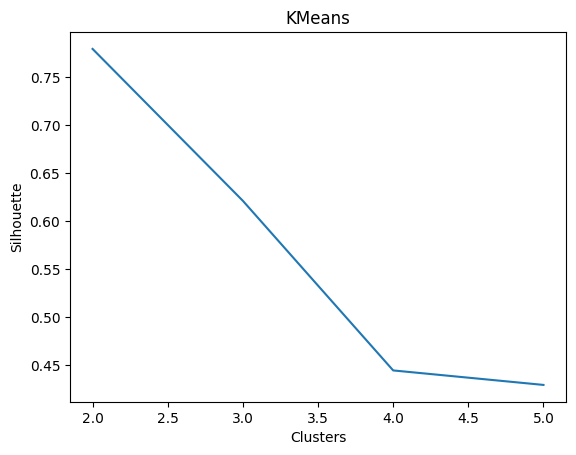

In [ ]:
plt.plot([k for k in range(2,6)], results_seed1)
plt.title('KMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/kmeans1.png')
# plt.show()

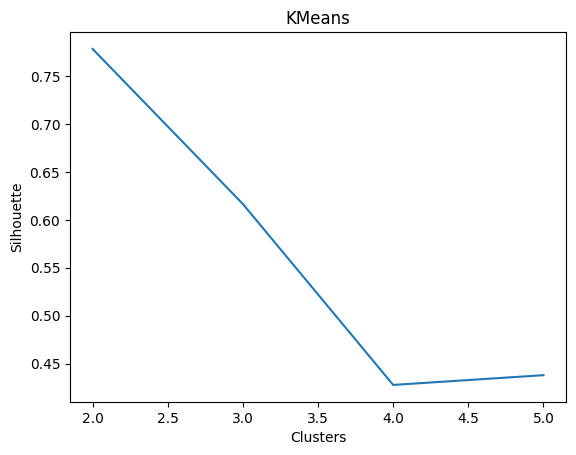

In [ ]:
plt.plot([k for k in range(2,6)], results_seed2)
plt.title('KMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/kmeans2.png')
# plt.show()

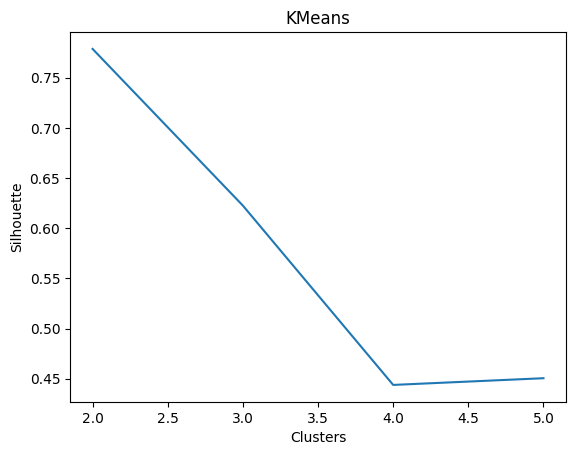

In [ ]:
plt.plot([k for k in range(2,6)], results_seed3)
plt.title('KMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/kmeans3.png')
# plt.show()

In [ ]:
results_seed1 = []
for k in range(2,6):
  bkmeans_silhouette, bkmeans_centers, model = clustering_bkmeans(mydf, k, 1)
  results_seed1.append(bkmeans_silhouette)

results_seed2 = []
for k in range(2,6):
  bkmeans_silhouette, bkmeans_centers, model = clustering_bkmeans(mydf, k, 2)
  results_seed2.append(bkmeans_silhouette)

results_seed3 = []
for k in range(2,6):
  bkmeans_silhouette, bkmeans_centers, model = clustering_bkmeans(mydf, k, 3)
  results_seed3.append(bkmeans_silhouette)

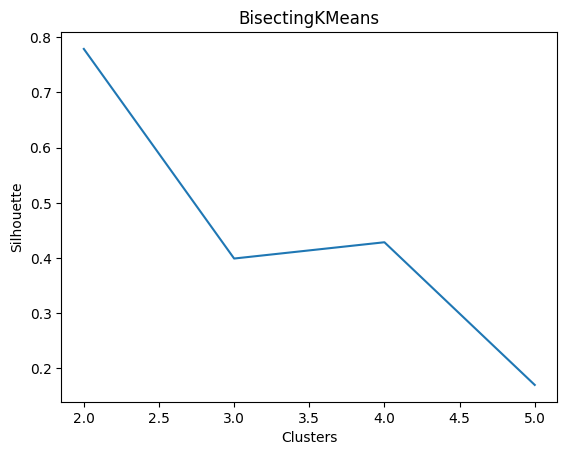

In [ ]:
plt.plot([k for k in range(2,6)], results_seed1)
plt.title('BisectingKMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/bkmeans1.png')
# plt.show()

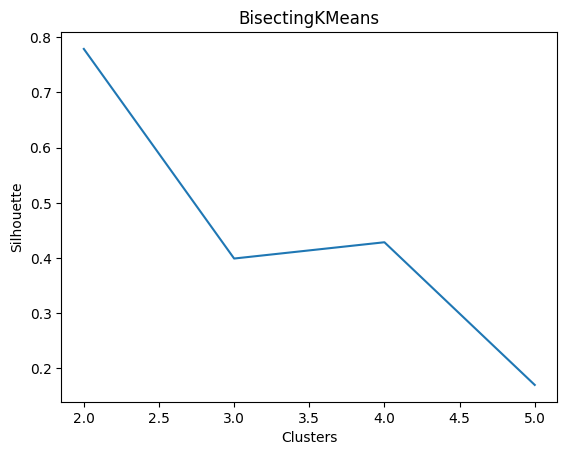

In [ ]:
plt.plot([k for k in range(2,6)], results_seed2)
plt.title('BisectingKMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/bkmeans2.png')
# plt.show()

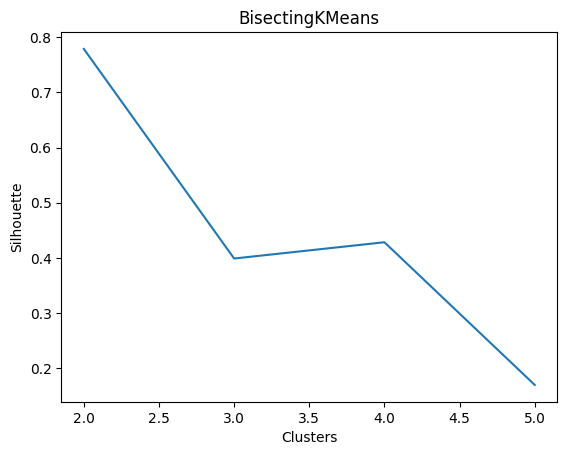

In [ ]:
plt.plot([k for k in range(2,6)], results_seed3)
plt.title('BisectingKMeans')
plt.xlabel('Clusters')
plt.ylabel('Silhouette')
plt.savefig('/content/outputs/models_plots/bkmeans3.png')
# plt.show()

Plots shows, that 2 clusters is the best number, of course, only a specialist can evaluate what kind of groups turned out and which of them is good and which is bad air. But I help to create a way to accurately determine the group to which air belongs.

I can not save model, so it's not necessary.
In future, to decide what kind of air we have, we need only to reduce features, create slides and calculate to what center coords they are closer.

In [ ]:
kmeans_silhouette, kmeans_centers, model = clustering_kmeans(mydf, 2, 1)
ans = f'This info saved to folder "models"\nBest number of KMeans clusters is 2, silhouette of square euqlidean distance = {kmeans_silhouette} with any seed, centers = {kmeans_centers}'
print(ans)
with open('/content/models/model_info.txt', 'w') as f:
    f.write(ans)


This info saved to folder "models"
Best number of KMeans clusters is 2, silhouette of square euqlidean distance = 0.7791446491258149 with any seed, centers = [array([-3333.44385958, -3414.20869863, -3347.71924081, -3211.73608927,
       -3238.12322273, -3274.46548468, -3262.27091121, -3254.54134088,
       -3300.81553817, -3272.37329858, -3165.770363  , -3015.1734681 ,
       -2829.50721901, -2665.60690827, -2519.27603171, -2531.5131387 ,
       -2466.6598531 , -2613.96329871, -2785.64132147, -3018.7750708 ,
       -3166.39142328, -3305.38720367, -3341.73913787, -3383.61905227]), array([-1044.20422337, -1033.88087792,  -984.30180536,  -955.92703199,
        -908.44663234,  -915.19791165,  -934.82661034,  -967.28473943,
       -1013.48469285, -1008.40422454,  -969.64579313,  -925.60575145,
        -881.95472129,  -833.8270541 ,  -797.05840817,  -781.44577082,
        -771.70285192,  -786.85799246,  -839.73681524,  -907.97493388,
        -966.87899971, -1006.91505262, -1026.80308658, -10

In [ ]:
# !pip freeze > requirements.txt